# Data Science Essentials: GeoPandas
    Ethan Crawford Taylor
    Math 402
    10/3/23

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
from IPython.display import HTML

## Problem 1

Read in the file *airports.csv* as a pandas DataFrame.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates (Longitude and Latitude zipped together) to a *shapely.geometry.Polygon* object.

Then, create a new GeoDataFrame using a dictionary with key *'geometry'* and with a list of these three Polygons as the value.
Plot this GeoDataFrame, and then plot the outlined world map on top of it.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport

/tmp/ipykernel_31638/842919084.py:37: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


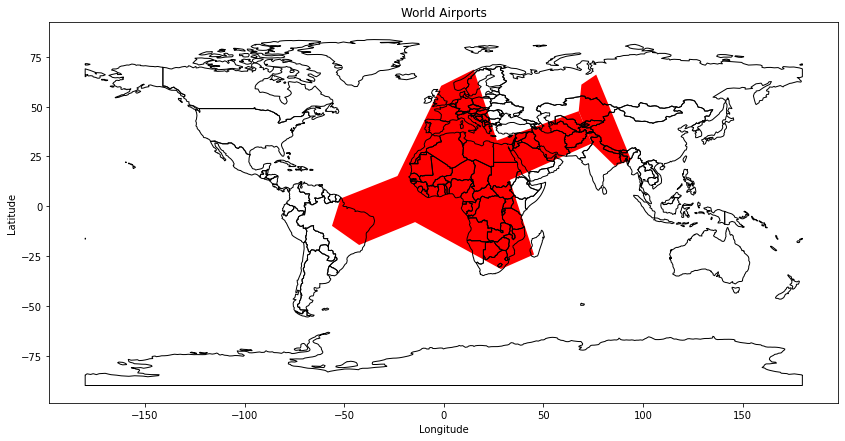

In [32]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

# Read in the airports data
airports = pd.read_csv('airports.csv')

# Make geometry column
airports['Coordinates'] = list(zip(airports.Longitude, airports.Latitude))

# Make geometry column Shapely objects
airports['Coordinates'] = airports['Coordinates'].apply(Point)

# Cast as GeoDataFrame
gdf = gpd.GeoDataFrame(airports, geometry='Coordinates')

# Read in the specific airports
first_df = gdf[gdf['Name'].isin(first_set)]
second_df = gdf[gdf['Name'].isin(second_set)]
third_df = gdf[gdf['Name'].isin(third_set)]

# Create a polygon with all three cities as points
first_city_polygon = Polygon(list(zip(first_df.Longitude, first_df.Latitude))).convex_hull
second_city_polygon = Polygon(list(zip(second_df.Longitude, second_df.Latitude))).convex_hull
third_city_polygon = Polygon(list(zip(third_df.Longitude, third_df.Latitude))).convex_hull

# create a new GeoDataFrame using a dictionary with key 'geometry' and with a
# list of these three Polygons as the value
city_polygons = gpd.GeoDataFrame(geometry=[first_city_polygon, second_city_polygon, third_city_polygon])

# Plot this GeoDataFrame, and then plot the outlined world map on top of it
# to see where these cities are
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)

city_polygons.plot(ax=base, marker='o', color='red', markersize=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('World Airports')
plt.show()

## Problem 2

Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the boundaries of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines (*dissolve*) all counties within each state (*by='STATEFP'*).
Drop regions with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot the boundary of this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

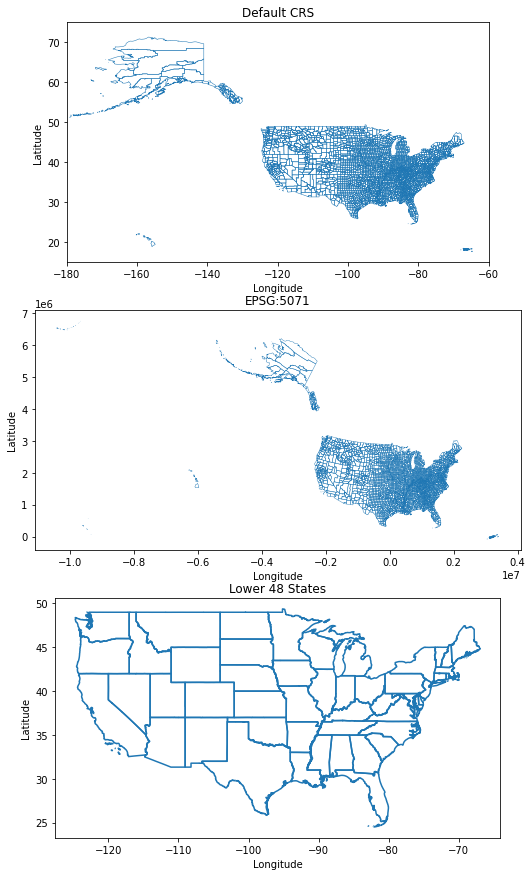

In [31]:
county_data = gpd.read_file('county_data.gpkg')

#Use this to plot the boundaries of all US counties two times, first 
# using the default CRS and then using EPSG:5071.
fig, ax = plt.subplots(figsize=(12,15), ncols=1, nrows=3)
base = county_data.boundary.plot(ax=ax[0], linewidth=0.5)
ax[0].set_title('Default CRS')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_xlim(-180, -60)
ax[0].set_ylim(15, 75)

county_data_5071 = county_data.to_crs(epsg=5071)
base = county_data_5071.boundary.plot(ax=ax[1], linewidth=0.4)
ax[1].set_title('EPSG:5071')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Drop Alaska, Hawaii, and Puerto Rico
for code in ['02', '15', '60', '66', '69', '72', '78']:
    county_data.drop(county_data[county_data['STATEFP'] == code].index, inplace=True)

# Plot the lower 48 states
states = county_data.dissolve(by='STATEFP')
base = states.boundary.plot(ax=ax[2])
ax[2].set_title('Lower 48 States')
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')
plt.show()

## Problem 3

Load in the file *nytimes.csv* as a Pandas DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.

Merge the county GeoDataFrame from *county_data.gpkg* with the *nytimes* DataFrame on the county *fips* codes (a FIPS code is a 5-digit unique identifier for geographic locations).
Note that the *fips* column of the *nytimes* DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three digits in the *COUNTYFP* column.
Thus, you will need to add these two columns together and then convert them into floats so they can be merged with the *fips* column in the *nytimes* DataFrame.

Drop the regions from the county GeoDataFrame with the same STATEFP codes as in Problem 2. Also, make sure to change the CRS of the county GeoDataFrame to EPSG:5071 *before* you merge the two DataFrames (this will make the code run much faster).

**Plot the cases from March 21, 2020, and then plot your state outline map from Problem 2 on top of that (with a CRS of EPSG:5071). 
Include a colorbar using the arguments *legend=True* and *cmap='PuBu_r'* in the *plot* function.
Finally, print out the name of the county with the most cases on March 21, 2020, along with its case count.**

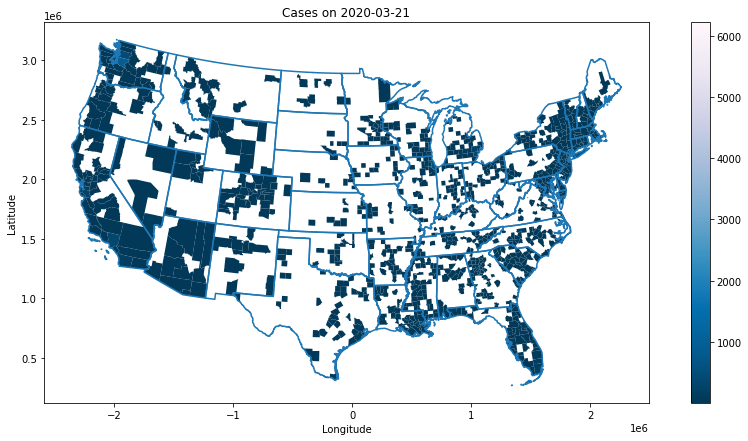

County with the most cases:
New York City with 6226 cases


In [70]:
# Load data
nytimes = pd.read_csv('nytimes.csv', index_col=0)
county_data = gpd.read_file('county_data.gpkg')

# Change the CRS of the county GeoDataFrame to EPSG:5071
county_data = county_data.to_crs(epsg=5071)

# Get correct fips code
county_data['fips'] = county_data['STATEFP'] + county_data['COUNTYFP']
county_data['fips'] = pd.to_numeric(county_data['fips'])

# Merge the two datasets
nytimes = nytimes.merge(county_data, on='fips')

# Drop Alaska, Hawaii, and Puerto Rico
for code in ['02', '15', '60', '66', '69', '72', '78']:
    nytimes.drop(nytimes[nytimes['STATEFP'] == code].index, inplace=True)
    county_data.drop(county_data[county_data['STATEFP'] == code].index, inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)
nytimes.set_index(pd.to_datetime(nytimes['date']),inplace=True)
nytimes.drop(columns='date',inplace=True)
nytimes = gpd.GeoDataFrame(nytimes, geometry='geometry')

# Plot the lower 48 states
states = county_data.dissolve(by='STATEFP')
base = states.boundary.plot(ax=ax)
# Plot the data
nytimes.loc['2020-03-21'].plot(ax=base,column='cases',cmap='PuBu_r',legend=True)
ax.set_title('Cases on 2020-03-21')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Get the county with the most cases
print("County with the most cases:")
indx = np.argmax(nytimes.loc['2020-03-21']['cases'])
print(nytimes.loc['2020-03-21'].iloc[indx]['county'], "with", nytimes.loc['2020-03-21'].iloc[indx]['cases'], "cases")

## Problem 4

As in Problem 3, plot your state outline map from Problem 2 on top of a map of Covid-19 cases from March 21, 2020 (each with a CRS of EPSG:5071).
This time, however, use a log scale.
Pick a good colormap (the counties with the most cases should generally be darkest) and be sure to display a colorbar.

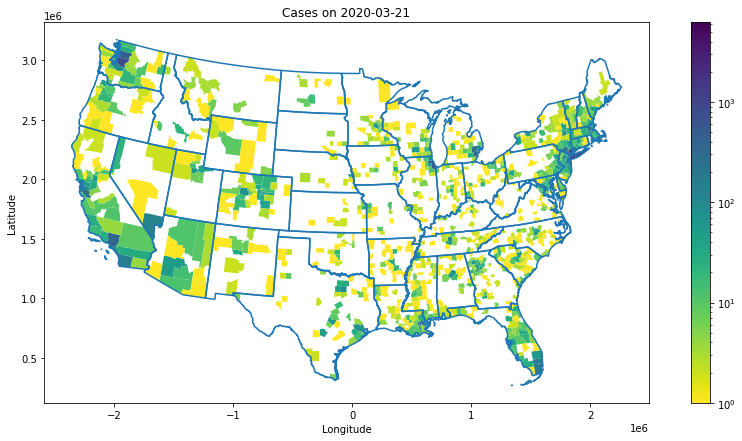

In [79]:
# Plot
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

# Plot the data
base = states.boundary.plot(ax=ax)
data = nytimes.loc['2020-03-21'].cases
nytimes.loc['2020-03-21'].plot(ax=base,column='cases',cmap='viridis_r',legend=True, norm= LogNorm(vmin=min(data), vmax=max(data)))
ax.set_title('Cases on 2020-03-21')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Problem 5

In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020, through June 21, 2020.
You will use the same GeoDataFrame you used in Problems 3 and 4 (with a CRS of EPSG:5071).
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your *vmax* so that the scale remains uniform.
- Write your *update* function. This should plot the cases from a given day as well as the state boundaries.
- Set up your colorbar. Do this outside the *update* function to avoid adding a new colorbar each day.
- Create a *FuncAnimation* object. Check to make sure everything displays properly before you save it.
- Save the animation to a file, and embed it into the notebook.

In [85]:
plt.ioff()

# Set up fig and norm
fig, ax = plt.subplots(1, figsize=(10,7))
base = states.boundary.plot(ax=ax)
norm = LogNorm(vmin=1, vmax= nytimes.cases.max())

def update(date):
    ax.clear()
    # Plot the state outlines
    base = states.boundary.plot(ax=ax)

    # Plot the cases by county from the specified date
    nytimes[nytimes.index == date].plot(ax=base, 
                                        column='cases', 
                                        cmap='viridis_r',
                                        norm=norm)
    ax.set_title("Spread of COVID-19 in the US")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.xticks([])
    plt.yticks([])
    plt.close()
    
# Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, 
                                   cmap='viridis_r'),
                                   ax=ax, 
                                   orientation='vertical', 
                                   pad=0, 
                                   label='# of Cases')

# Create animation object
ani = animation.FuncAnimation(fig, update, 
        frames=sorted(set(nytimes.index)),
        interval=1000*(1/30)) # Each frame is 1/30 of a second
plt.close(fig)

In [86]:
animation.writer = animation.writers['ffmpeg']

# Save / embed the animation

# Run this line and the following Markdown cell
ani.save('covid_spread.mp4')
# Don't forget to push the .mp4 file!

<video src="covid_spread.mp4" controls>